In [1]:
import cv2
import os
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

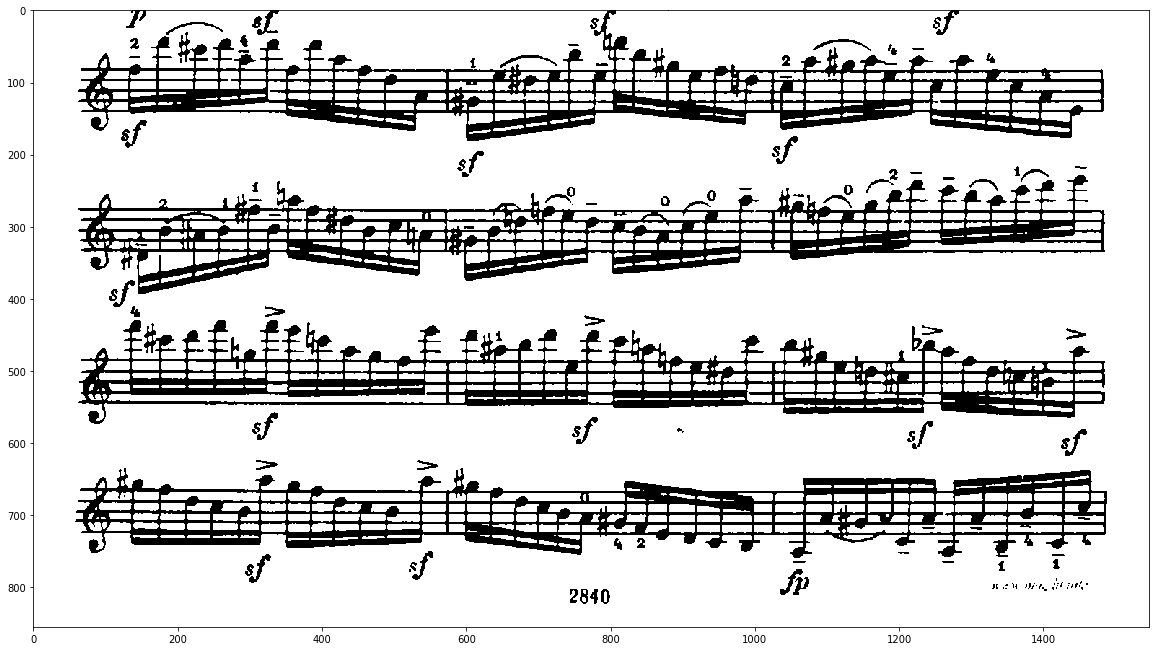

In [93]:
# Reading the file
note_path = 'note2.png'
note = cv2.imread(note_path)
note = cv2.cvtColor(note, cv2.COLOR_BGR2GRAY)
note = cv2.medianBlur(note, 3)

# Let's just work with the bottom half first
note = note[note.shape[0] // 2 + 200:, :]
#note = note[:note.shape[0] // 2 + 200, :]

# Filter out the gray stuff, custom step
ret, thresh = cv2.threshold(note, 127, 255, cv2.THRESH_BINARY)

# Visualization
plt.figure(figsize=(20, 12))
plt.imshow(thresh, 'gray')

# Let's see what we have now, visualization is very important
# plt.figure(figsize=(20, 12))
# plt.imshow(note, 'gray')

# Outline the most important variables
GLOBAL_note = thresh

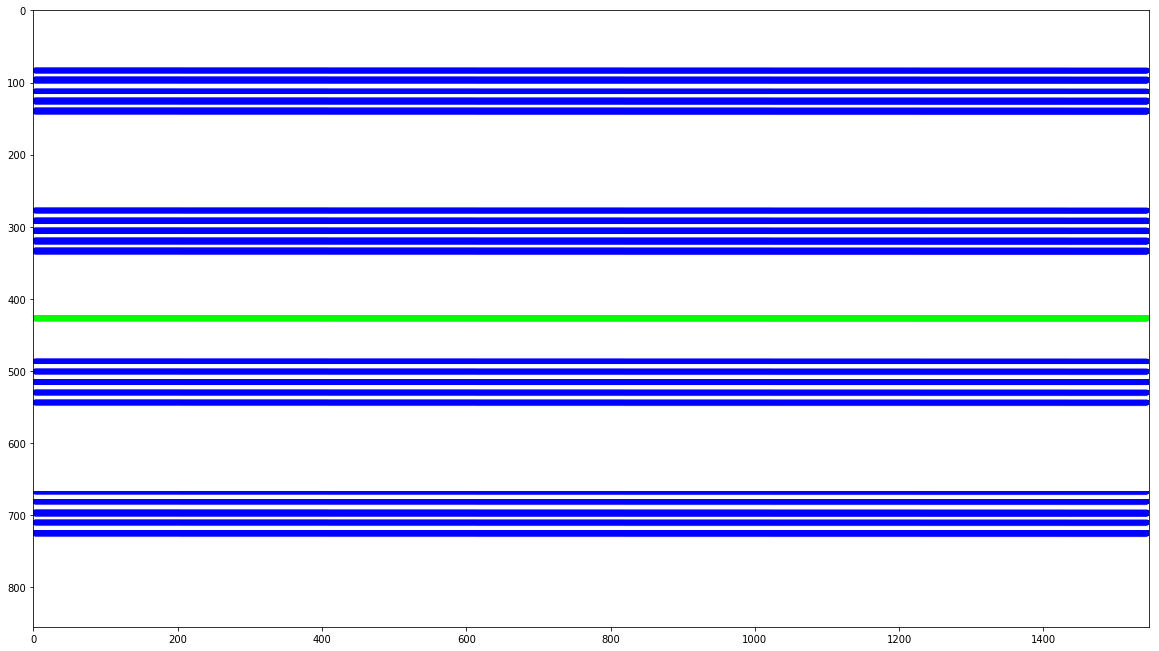

In [94]:
# Detect edges
note_edges = cv2.Canny(GLOBAL_note, 100, 200, None, 3)

def display_line(img, rho, theta, thicc=3, color=(0, 0, 0)):
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 3000*(-b)), int(y0 + 3000*(a)))
    pt2 = (int(x0 - 3000*(-b)), int(y0 - 3000*(a)))
    cv2.line(img, pt1, pt2, color, thicc, cv2.LINE_AA)
    
# Copy of image
whites = np.ones((GLOBAL_note.shape[0], GLOBAL_note.shape[1], 3), dtype=np.uint8) * 255

# Find lines from edges
lines = cv2.HoughLines(note_edges, 1, np.pi / 180, 300)
assert lines is not None

# Predominant angle
thetas = lines[:, 0, 1]
thetas_std = np.std(thetas)
thetas_mean = np.mean(thetas)
thetas = thetas[(thetas_mean - thetas_std - 1e-4 < thetas) &
                (thetas < thetas_mean + thetas_std + 1e-4)]
dominant_angle = np.median(thetas)

# Filter out lines that does not match the dominant direction
thetas = lines[:, 0, 1]
lines = lines[(dominant_angle - 1e-2 < thetas) &
              (thetas < dominant_angle + 1e-2)]

# Sort the lines by rho value
rhos = lines[:, 0, 0]
args = np.argsort(rhos)
lines = lines[args, :, :]

# Visualize lines and the dominant direction
rho = whites.shape[0] // 2
theta = dominant_angle
display_line(whites, rho, theta, 7, (0, 255, 0))
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    display_line(whites, rho, theta, 3, (0, 0, 255))
plt.figure(figsize=(20, 12))
plt.imshow(whites, 'gray')

# Cell's conclusion
GLOBAL_dominant_angle = dominant_angle

In [95]:
# TODO: Rotate the image in such a way, so that the predominant angle
# become horizontal
GLOBAL_dominant_angle = GLOBAL_dominant_angle

in-band range: 13.0 ... 15.0
ex-band range: 125.0 ... 152.0
number of bands: 4
before filtering lines: 39  lines
after filtering proper lines: 20  lines


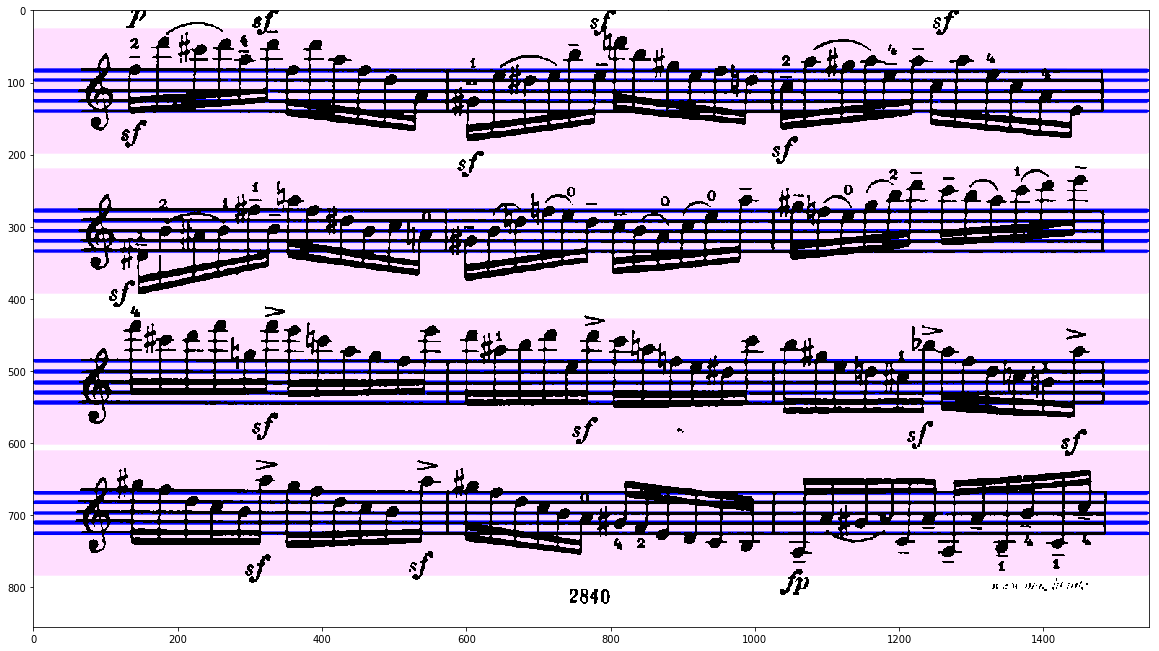

In [96]:
# Filter out the lines that are too close to each other
linewidth_threshold = 7
proper_lines = []
lines_pool = []
prev_rho = None
for i in range(len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    if prev_rho is None:
        prev_dst = 1000000
    else:
        prev_dst = abs(rho - prev_rho)
    if len(lines_pool) != 0:
        if prev_dst > linewidth_threshold:
            avg_rho = np.round(np.mean(np.array(lines_pool)[:, 0]))
            avg_theta = np.mean(np.array(lines_pool)[:, 1])
            proper_lines.append([avg_rho, avg_theta])
            lines_pool = []
    prev_rho = rho
    lines_pool.append([rho, theta])

avg_rho = np.mean(np.array(lines_pool)[:, 0])
avg_theta = np.mean(np.array(lines_pool)[:, 1])
proper_lines.append([avg_rho, avg_theta])
proper_lines = np.array(proper_lines)[:, np.newaxis, :]

# Find the bands
rho_cp = proper_lines[:, 0, 0].copy()
rho_le = np.concatenate((np.zeros((1)), rho_cp))
rho_ri = np.concatenate((rho_cp, np.zeros((1))))
rho_dt = rho_le - rho_ri
rho_dt = np.abs(rho_dt[1:-1])
rho_inband_min = np.min(rho_dt)
rho_exband_max = np.max(rho_dt)
rho_inband_max = rho_inband_min
rho_exband_min = rho_exband_max
rho_inband_vals = []
rho_exband_vals = []
for rho in rho_dt:
    if abs(rho - rho_inband_min) < abs(rho - rho_exband_max):
        rho_inband_max = max(rho, rho_inband_max)
        rho_inband_vals.append(rho)
    else:
        rho_exband_min = min(rho, rho_exband_min)
        rho_exband_vals.append(rho)
print('in-band range:', rho_inband_min, '...', rho_inband_max)
print('ex-band range:', rho_exband_min, '...', rho_exband_max)
band_list = []
band_pool = []
prev_rho = None
for i in range(len(proper_lines)):
    rho = proper_lines[i][0][0]
    theta = proper_lines[i][0][1]
    if prev_rho is not None:
        if abs(rho - prev_rho) <= rho_inband_max:
            None
        if abs(rho - prev_rho) >= rho_exband_min:
            band_pool = np.array(band_pool)
            band_list.append([
                np.round(np.mean(band_pool[:, 0])),
                np.mean(band_pool[:, 1]),
                abs(np.max(band_pool[:, 0]) - np.min(band_pool[:, 0]))])
            band_pool = []
    band_pool.append([rho, theta])
    prev_rho = rho
band_pool = np.array(band_pool)
band_list.append([
    np.round(np.mean(band_pool[:, 0])),
    np.mean(band_pool[:, 1]),
    abs(np.max(band_pool[:, 0]) - np.min(band_pool[:, 0]))])
band_list = np.array(band_list)[:, np.newaxis, :]
print('number of bands:', band_list.shape[0])

# Visualize the proper lines
print('before filtering lines:', lines.shape[0], ' lines')
print('after filtering proper lines:', proper_lines.shape[0], ' lines')
bgr_thresh = cv2.cvtColor(GLOBAL_note, cv2.COLOR_GRAY2BGR)
white = np.ones(bgr_thresh.shape, dtype=np.uint8) * 255
for i in range(0, len(band_list)):
    rho = band_list[i][0][0]
    theta = band_list[i][0][1]
    thicc = band_list[i][0][2]
    display_line(white, rho, theta, int(thicc + rho_exband_min - 10), (255, 222, 255))
for i in range(0, len(proper_lines)):
    rho = proper_lines[i][0][0]
    theta = proper_lines[i][0][1]
    display_line(white, rho, theta, 3, (0, 0, 255))
bgr_thresh = np.minimum(bgr_thresh, white)
plt.figure(figsize=(20, 12))
plt.imshow(bgr_thresh)

# Conclusion
GLOBAL_lines = proper_lines
GLOBAL_bands = band_list
GLOBAL_rho_inband_vals = np.array(rho_inband_vals)
GLOBAL_rho_exband_vals = np.array(rho_exband_vals)

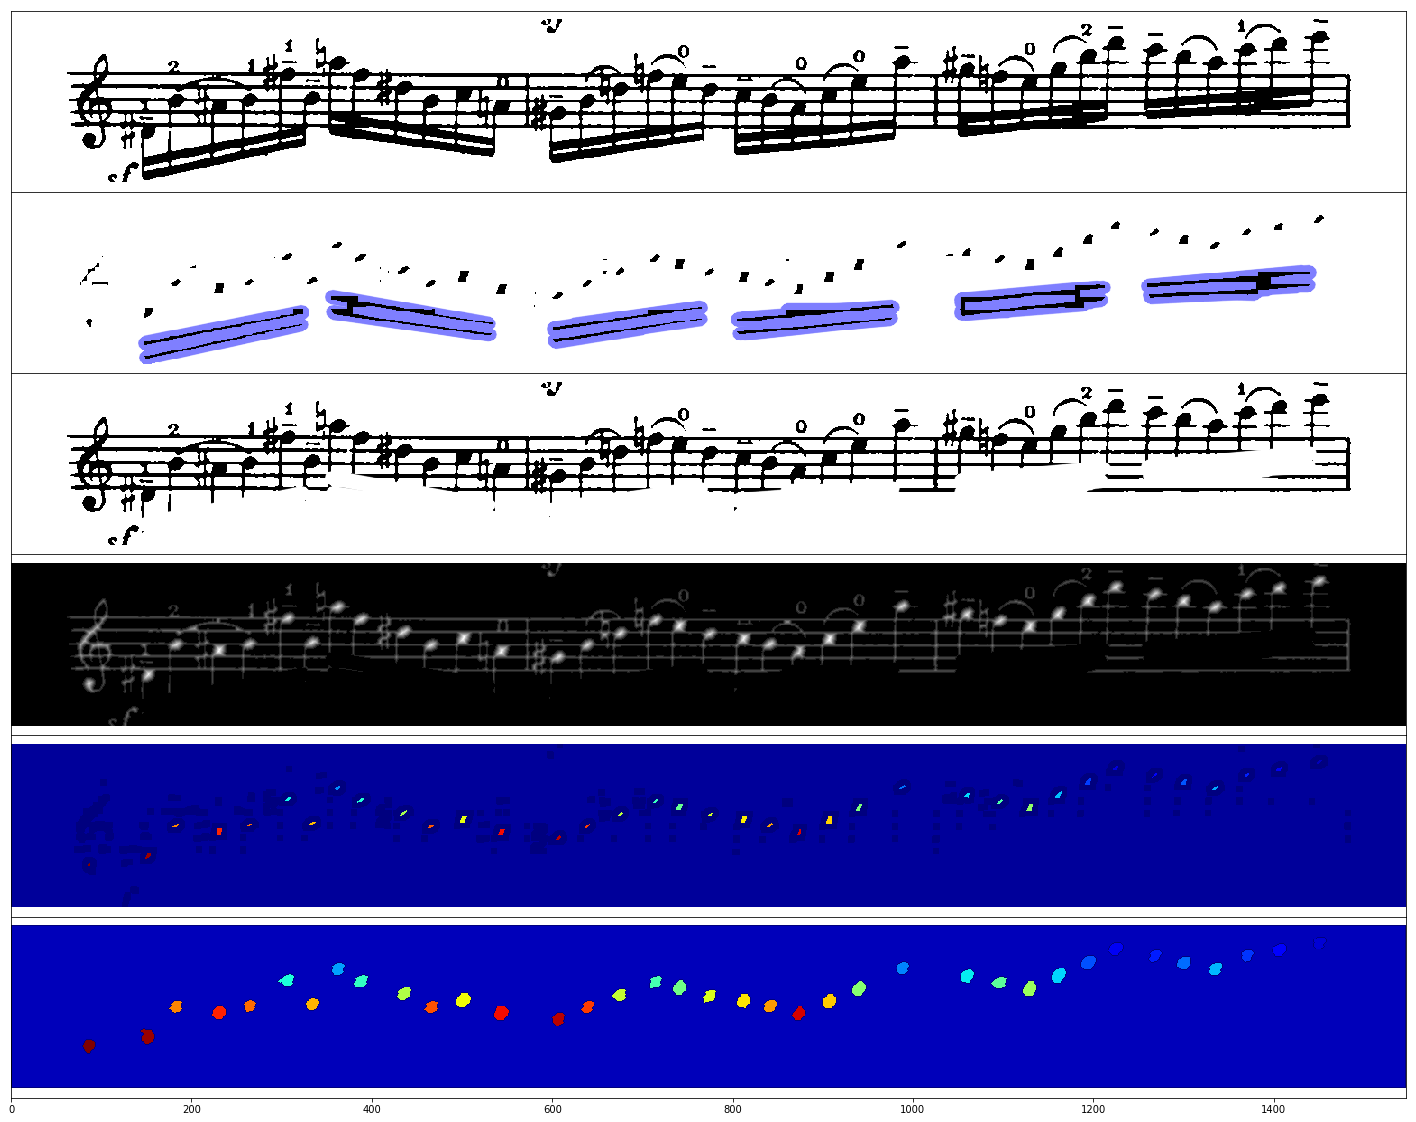

In [101]:
band_index = 1

# Get the band
rho = GLOBAL_bands[band_index, 0, 0]
theta = GLOBAL_bands[band_index, 0, 1]
thicc = GLOBAL_bands[band_index, 0, 2]
rho_lo = int(rho - ((thicc + np.min(GLOBAL_rho_exband_vals)) // 2))
rho_hi = int(rho + ((thicc + np.min(GLOBAL_rho_exband_vals)) // 2))
band = GLOBAL_note[rho_lo:rho_hi, :].copy()

# Getting rid of thicc lines
band_nobrows = band.copy()
kernel3 = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(band_nobrows, kernel3, iterations=3)
dilated_color = cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR)
whites = np.ones(dilated_color.shape, dtype=np.uint8) * 255
linesP = cv2.HoughLinesP(255 - dilated, 1, np.pi / 180, 50, None, 50, 20)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(band_nobrows, (l[0], l[1]), (l[2], l[3]), (255), 13, cv2.LINE_AA)
        cv2.line(whites, (l[0], l[1]), (l[2], l[3]), (127,127,255), 13, cv2.LINE_AA)
dilated_color = np.minimum(dilated_color, whites)

# Negative band
nobrows_negative = 255 - band_nobrows

# Erode a bit
kernel3 = np.ones((3, 3), np.uint8) 
opening = cv2.morphologyEx(nobrows_negative, cv2.MORPH_OPEN, kernel3, iterations=2)

# Find sure background
sure_bg = cv2.dilate(opening, kernel3, iterations=1)

# Find pixels that surely belogns to notes
dist_transform = cv2.distanceTransform(nobrows_negative, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0
pre_markers = markers.copy()

# Watershed
markers = cv2.watershed(cv2.cvtColor(band, cv2.COLOR_GRAY2BGR), markers)

# Visualization
f, axes = plt.subplots(6, sharex=True, figsize=(25, 20))
axes[0].imshow(band, 'gray')
axes[1].imshow(dilated_color, 'gray')
axes[2].imshow(band_nobrows, 'gray')
axes[3].imshow(dist_transform, 'gray')
axes[4].imshow(pre_markers, cmap='jet')
axes[5].imshow(markers, cmap='jet')
f.subplots_adjust(hspace=0)
for ax in axes:
    ax.set_yticks([])

# Conclusion


In [53]:
band_index = 1

# Get the band
rho = GLOBAL_bands[band_index, 0, 0]
theta = GLOBAL_bands[band_index, 0, 1]
thicc = GLOBAL_bands[band_index, 0, 2]
rho_lo = int(rho - ((thicc + np.min(GLOBAL_rho_exband_vals)) // 2))
rho_hi = int(rho + ((thicc + np.min(GLOBAL_rho_exband_vals)) // 2))
band = GLOBAL_note[rho_lo:rho_hi, :].copy()

